# Data Visualization

1.​ Visualize the spatial distribution of key datasets using geopandas and matplotlib (or other tools if you want):

○​ Plot groundwater sources ('ergw1000_gwerg__v11_poly.csv') and overlay mining areas
('ergw1000_bergbaugebiete__v1_poly.csv').

○​ Create a choropleth map highlighting the distribution of different rock types ('ergw1000_gwerg_gestein_v1_poly.csv').

○​ Generate a histogram of groundwater extraction rates ('entn_bru') across different geological formations.

2.​ Provide insights based on the visualizations:

○​ Are there significant overlaps between important groundwater sources and mining areas?

○​ Which geological formations are most common in high-extraction regions?
 


unique datasets: 
-   bergbaugebiete_v1_poly
-   gwerg_erg_v11_poly
-   gwerg_gestein_v1_poly
-   gwerg__v11_poly
-   uferfiltrat_v1_poly
-   uferfiltrat_v1_line

In [18]:
# Import necessary packages
from dbfread import DBF
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import os
import pandas as pd
from pyhere import here



In [7]:
# datasets not provided as csvs. 
# screen folder for .dbf, .shp, and .prj files, load as (geo)pandas dfs, save (g)dfs in dicts with filenames as keys
dfs = {}
gdfs = {}
folder_path = here("ERGW1000/ERGW1000_v1/shp")
for file in os.listdir(folder_path):
    if file.endswith(".dbf"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".dbf", "")
        path_to_file = os.path.join(folder_path, file)
        table = DBF(path_to_file, load=True,  encoding="utf-8")
        #convert to pandas df
        df = pd.DataFrame(iter(table))
        #save to dict
        dfs[filename] = df
    if file.endswith(".shp"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".shp", "")
        path_to_shapefile = os.path.join(folder_path, file)
        gdf = gpd.read_file(path_to_shapefile)
        #save to dict
        gdfs[filename] = gdf


### ​Groundwater sources and mining areas 

In [21]:
water_gdf = gdfs['gwerg__v11_poly']
water_gdf = water_gdf[water_gdf['erg_id'].isin([11,12,13])] # limit groundwater sources to relevant ones
mining_gdf = gdfs['bergbaugebiete__v1_poly']

In [25]:
# for plotting, transform to geographic CRS (to plot latitude and longitude on axes)
water_gdf = water_gdf.to_crs(epsg=4326)
mining_gdf = mining_gdf.to_crs(epsg=4326)

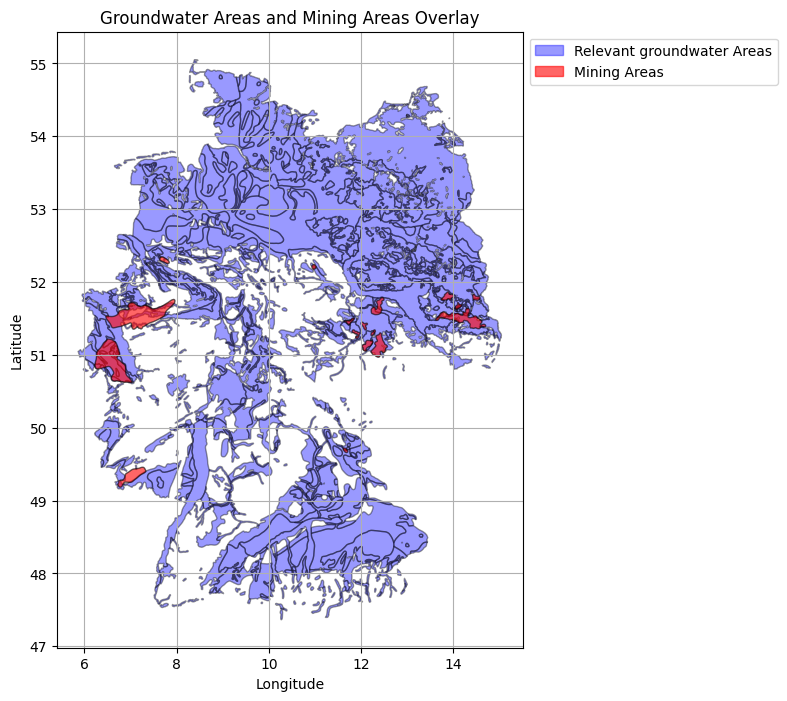

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
# Plot groundwater areas
water_gdf.plot(ax=ax, color="blue", alpha=0.4, edgecolor="black", label="Groundwater Areas")

# Overlay mining areas
mining_gdf.plot(ax=ax, color="red", alpha=0.6, edgecolor="black", label="Mining Areas")

plt.title("Groundwater Areas and Mining Areas Overlay")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# make legend
blue_patch = mpatches.Patch(color="blue", alpha=0.4, label="Relevant groundwater Areas")
red_patch = mpatches.Patch(color="red", alpha=0.6, label="Mining Areas")
plt.legend(handles=[blue_patch, red_patch], loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)

# Show the plot
plt.show()
plt.close()
